In [1]:
import re
import gensim
from gensim.parsing.preprocessing import strip_punctuation, strip_short, strip_numeric, strip_multiple_whitespaces, remove_stopwords
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import urllib.request
import zipfile
import lzma
import shutil
import matplotlib.pyplot as plt

In [2]:
import logging
logging.basicConfig(level=logging.INFO, force = True)
logger = logging.getLogger()
logger.info("Logging initialized")

INFO:root:Logging initialized


In [3]:
#Link found here: https://metatext.io/datasets/cc100-belarusian
urllib.request.urlretrieve('https://data.statmt.org/cc-100/be.txt.xz', 
                           'be.txt.xz')

urllib.request.urlretrieve('https://github.com/Belarus/GrammarDB/archive/refs/tags/PUBLICATION_2021.zip', 
                           'GrammarDB.zip')

('GrammarDB.zip', <http.client.HTTPMessage at 0x17a7a8290>)

In [4]:
with lzma.open("be.txt.xz", "rb") as fsrc:
    with open("be.txt", "wb") as fdst:
        shutil.copyfileobj(fsrc, fdst)

with zipfile.ZipFile('GrammarDB.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [5]:
import xml.dom.minidom
from itertools import islice

def calculate_mapping_from_forms_to_base(filepath, tag_prefix1="", tag_prefix2=""):
    xml_doc = xml.dom.minidom.parse(filepath)
    paradigms = xml_doc.getElementsByTagName('Paradigm')
    result = {}
    collision_count = 0
    collisions = set()
    for paradigm in paradigms:
        tag = paradigm.getAttribute('tag')
        if tag.startswith(tag_prefix1) or tag.startswith(tag_prefix2):
            variants = paradigm.getElementsByTagName('Variant')
            for variant in variants:
                base = variant.getAttribute('lemma').replace("+", "").lower()
                forms = variant.getElementsByTagName('Form')
                local_map = {}
                citation_count = max([form.getAttribute('slouniki').count(',') for form in forms]) + 1
                for form in forms:
                    if len(form.childNodes) > 0:
                        word = form.childNodes[0].data.replace("+", "").lower()
                        local_map[word] = (base, citation_count)
                for k, v in local_map.items():
                    if k in result:
                        if result[k][1] == v[1] and result[k][0] != v[0]:
                            collision_count += 1
                            collisions.add(v[0])
                            collisions.add(result[k][0])
                        elif result[k][1] < v[1]:
                            result[k] = v
                    else:
                        result[k] = v
                    
    logger.info(f"Collisions (forms leading to different base word, and having same amount of citation): {collision_count}")
    logger.info(f"Examples of collisions: {list(islice(collisions, 5))}")
    for k in result:
        result[k] = result[k][0]
    return result

In [6]:
#verbs
v = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/V.xml')

#proper nouns
np = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/NP.xml', 'NPII')

#nouns
n1 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/N1.xml')
n2 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/N2.xml')
n3 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/N3.xml')

#adjectives
adj1 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/A1.xml', 'ARP', 'AQP')
adj2 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/A2.xml', 'ARP', 'AQP')

WORD_MAP = {}
WORD_MAP.update(v)
WORD_MAP.update(np)
WORD_MAP.update(n1)
WORD_MAP.update(n2)
WORD_MAP.update(n3)
WORD_MAP.update(adj1)
WORD_MAP.update(adj2)

INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 2597
INFO:root:Examples of collisions: ['пагрукатаць', 'дайграваць', 'зжэрціся', 'патрысціць', 'замірацца']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 139
INFO:root:Examples of collisions: ['полацк', 'марк', 'каспараў', 'валер', 'жан']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 1345
INFO:root:Examples of collisions: ['арчынец', 'генетык', 'баск', 'далмацінка', 'заафіт']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 1155
INFO:root:Examples of collisions: ['мыт', 'кумок', 'канянё', 'пабіцце', 'пачуцце']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 954
INFO:root:Examples of collisions: ['сума', 'трэска', 'ціролец', 'хронік', 'электратэхнік']
INFO:root:Collisions (forms leading to differ

In [7]:
print(len(WORD_MAP))

2273218


In [8]:
print(WORD_MAP['рухам'])
print(WORD_MAP['беларусі'])

рух
беларусь


In [9]:
def strip_trailing_newline(iterable):
    for i in iterable:
        yield i.rstrip()

CHARACTERS_MAP = {'ý': 'ў', 'i': 'і', 'ньн': 'нн', 'цьц': 'цц', 'сьц': 'сц', 'сьл':'сл', 'дзьдз': 'ддз', ' ў': 'у'}
def replace_characters(iterable):
    for s in iterable:
        for k, v in CHARACTERS_MAP.items():
            s = s.replace(k, v)
        yield s

def split_sentences(iterable):
    for i in iterable:
        merged_dots = re.sub("[\.]+", ".", i)
        sentences = merged_dots.split('.')
        for s in sentences:
            yield s

STOPWORDS = ['на', 'не', 'што', 'да', 'па', 'як', 'за', 'для', 'гэта', 'ад', 'але', 'калі', 'пра', 'у', 'яго', 'якія', 'ён', 'іх', 'мы', 'каб', 'толькі', 'аб', 'таксама', 'які', 'ці', 'быў', 'было', 'яны', 'так', 'вы', 'яе', 'будзе', 'пры', 'яшчэ', 'тым', 'таму', 'вельмі', 'былі', 'можна', 'яна', 'пасля', 'пад', 'можа', 'дзе', 'якая', 'тут', 'была', 'трэба', 'тое', 'таго', 'або', 'гэтым', 'бо', 'ўсё', 'хто', 'ня', 'нас', 'гэтага', 'быць', 'гэты', 'ёсць', 'праз', 'ўжо', 'са', 'нават', 'то', 'мяне', 'ім','ва', 'той', 'усе', 'без', 'чым', 'мне', 'мае', 'сябе', 'гэтай', 'там', 'усё', 'вось', 'ды', 'каля', 'якіх', 'ты', 'якой', 'ўсе', 'жа', 'ужо', 'паводле', 'будуць', 'аднак', 'могуць', 'сваю', 'ні', 'сваёй', 'яму', 'свае', 'гэтыя', 'проста', 'ўсіх', 'якім', 'падчас', 'тады', 'свой', 'вас', 'паміж', 'нам', 'раз', 'сваіх', 'нашай', 'менавіта', 'перад', 'вам', 'тых','зь','такім', 'свайго', 'над', 'зараз', 'амаль', 'чаму', 'ёй', 'чынам', 'напрыклад', 'якога', 'якое', 'сваім', 'можаце', 'га', 'хоць', 'бы', 'тыя', 'такія', 'потым', 'адным', 'такі', 'якую', 'сабе','сам','гэтых','мая','наш','зусім','чаго','наша','зноў','дык','такіх','нашага','адразу','каго','самі','ст','ну','нашы','нашым','самы','яно','гэтае','дзеля','куды','by','гг']
def preprocess_sentences(iterable):
    for i in iterable:
        s = strip_multiple_whitespaces(strip_numeric(strip_short(strip_punctuation(i))))
        s = s.lower()
        s = re.sub("[«»“”„…—°′²]", "", s)
        s = remove_stopwords(s, stopwords=STOPWORDS)
        s = ' '.join([WORD_MAP[w] for w in s.split() if w in WORD_MAP])
        yield s

def remove_short_lines(iterable):
    for i in iterable:
        if not i.isspace() and len(i) >= 20:
            yield i


In [10]:
with open('be.txt', 'r') as original_file:
    with open('processed-corpus.txt', 'w') as sentences_file:
        for s in remove_short_lines(preprocess_sentences(split_sentences(replace_characters(strip_trailing_newline(original_file))))):
            sentences_file.write(s + "\n")

In [11]:
loss_list = []
class Callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_list.append(loss)
        logger.info('Loss after epoch {}:{}'.format(self.epoch, loss))
        model.running_training_loss = 0.0
        self.epoch = self.epoch + 1

In [12]:
model = Word2Vec(vector_size=100, window=3, min_count=10, workers=5)

INFO:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.025>', 'datetime': '2023-04-26T11:50:35.854939', 'gensim': '4.3.1', 'python': '3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]', 'platform': 'macOS-12.6-x86_64-i386-64bit', 'event': 'created'}


In [13]:
sentences = LineSentence('processed-corpus.txt')

In [14]:
model.build_vocab(sentences, progress_per=5000000)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #5000000, processed 38306344 words, keeping 101549 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000000, processed 76685325 words, keeping 114693 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #15000000, processed 114979417 words, keeping 122208 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000000, processed 153329676 words, keeping 127145 word types
INFO:gensim.models.word2vec:collected 129310 word types from a corpus of 173972373 raw words and 22704237 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 78772 unique words (60.92% of original 129310, drops 50538)', 'datetime': '2023-04-26T11:51:39.649635', 'gensim': '4.3.1', 'python':

In [15]:
#we override alpha with small values, since default values result in poor train performance. See loss plot below
model.train(sentences, epochs=100, start_alpha=0.0001, end_alpha=0.00001, total_examples=model.corpus_count, total_words=model.corpus_total_words, compute_loss=True, report_delay=300, callbacks=[Callback()])


INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'training model with 5 workers on 78772 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3 shrink_windows=True', 'datetime': '2023-04-26T11:51:40.450292', 'gensim': '4.3.1', 'python': '3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]', 'platform': 'macOS-12.6-x86_64-i386-64bit', 'event': 'train'}
INFO:gensim.models.word2vec:EPOCH 0 - PROGRESS: at 0.85% examples, 1435522 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 0: training on 173972373 raw words (170383158 effective words) took 126.8s, 1343981 effective words/s
INFO:root:Loss after epoch 0:35211104.0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 0.81% examples, 1343085 words/s, in_qsize 8, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1: training on 173972373 raw words (170381388 effective words) took 122.2s, 1394703 effective words/s
INFO:root:Loss after epoch 1:44794812.0
INFO:gensim.models.word2

INFO:gensim.models.word2vec:EPOCH 27: training on 173972373 raw words (170384694 effective words) took 118.2s, 1441341 effective words/s
INFO:root:Loss after epoch 27:37670556.0
INFO:gensim.models.word2vec:EPOCH 28 - PROGRESS: at 0.82% examples, 1393520 words/s, in_qsize 8, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 28: training on 173972373 raw words (170380280 effective words) took 117.2s, 1453177 effective words/s
INFO:root:Loss after epoch 28:37434380.0
INFO:gensim.models.word2vec:EPOCH 29 - PROGRESS: at 0.80% examples, 1345104 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 29: training on 173972373 raw words (170383211 effective words) took 118.4s, 1438794 effective words/s
INFO:root:Loss after epoch 29:37672236.0
INFO:gensim.models.word2vec:EPOCH 30 - PROGRESS: at 0.79% examples, 1345240 words/s, in_qsize 7, out_qsize 3
INFO:gensim.models.word2vec:EPOCH 30: training on 173972373 raw words (170381009 effective words) took 118.7s, 1434937 effective words/s
IN

INFO:gensim.models.word2vec:EPOCH 56 - PROGRESS: at 0.85% examples, 1431765 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 56: training on 173972373 raw words (170381246 effective words) took 118.0s, 1443490 effective words/s
INFO:root:Loss after epoch 56:36980868.0
INFO:gensim.models.word2vec:EPOCH 57 - PROGRESS: at 0.80% examples, 1356076 words/s, in_qsize 7, out_qsize 2
INFO:gensim.models.word2vec:EPOCH 57: training on 173972373 raw words (170384439 effective words) took 119.9s, 1420877 effective words/s
INFO:root:Loss after epoch 57:36968420.0
INFO:gensim.models.word2vec:EPOCH 58 - PROGRESS: at 0.85% examples, 1418032 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 58: training on 173972373 raw words (170380913 effective words) took 119.4s, 1427087 effective words/s
INFO:root:Loss after epoch 58:36977560.0
INFO:gensim.models.word2vec:EPOCH 59 - PROGRESS: at 0.79% examples, 1336789 words/s, in_qsize 8, out_qsize 1
INFO:gensim.models.word2vec:EP

INFO:root:Loss after epoch 84:36932208.0
INFO:gensim.models.word2vec:EPOCH 85 - PROGRESS: at 0.81% examples, 1366713 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 85: training on 173972373 raw words (170381191 effective words) took 118.5s, 1437582 effective words/s
INFO:root:Loss after epoch 85:36828692.0
INFO:gensim.models.word2vec:EPOCH 86 - PROGRESS: at 0.80% examples, 1345062 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 86: training on 173972373 raw words (170379302 effective words) took 118.4s, 1439362 effective words/s
INFO:root:Loss after epoch 86:36901040.0
INFO:gensim.models.word2vec:EPOCH 87 - PROGRESS: at 0.81% examples, 1355838 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 87: training on 173972373 raw words (170379227 effective words) took 117.2s, 1453268 effective words/s
INFO:root:Loss after epoch 87:36864280.0
INFO:gensim.models.word2vec:EPOCH 88 - PROGRESS: at 0.82% examples, 1397570 words/s, in_qsize 8, o

(17038114896, 17397237300)

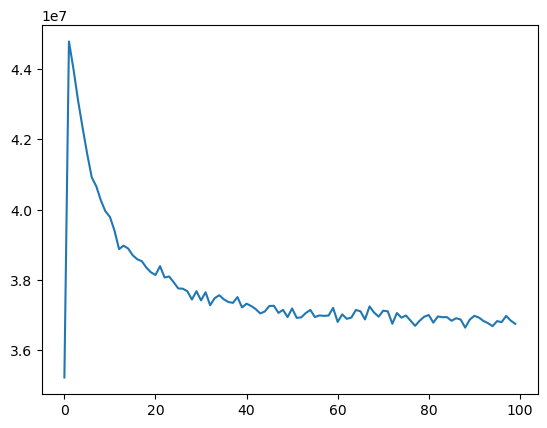

In [16]:
plt.plot(loss_list)

For comaprison, below is the loss plot when using default (larger) values for alpha. Note, that during training alpha is decreasing linearly from start value to end value. With default values in use the loss goes down near the end, once alpha gets smaller values.

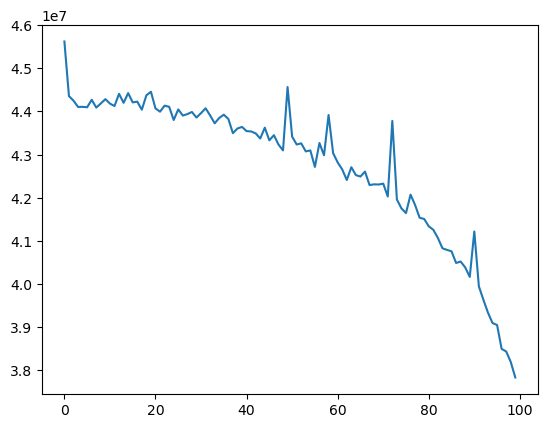

In [17]:
default_alpha_loss_list = [45621836.0, 44355904.0, 44249936.0, 44104492.0, 44107028.0, 44097436.0, 44270596.0, 44089604.0, 44185456.0, 44285424.0, 44182396.0, 44126032.0, 44408908.0, 44199988.0, 44425624.0, 44209516.0, 44227556.0, 44041368.0, 44373620.0, 44456688.0, 44070200.0, 43995008.0, 44134528.0, 44107632.0, 43802268.0, 44047244.0, 43904480.0, 43939264.0, 43987436.0, 43859148.0, 43961468.0, 44073332.0, 43907992.0, 43725336.0, 43849884.0, 43924944.0, 43826232.0, 43496588.0, 43605268.0, 43641544.0, 43543980.0, 43537204.0, 43491140.0, 43373268.0, 43624628.0, 43330720.0, 43449924.0, 43234040.0, 43097712.0, 44565932.0, 43416728.0, 43234072.0, 43260536.0, 43074152.0, 43096868.0, 42714596.0, 43268708.0, 42984456.0, 43917916.0, 43035192.0, 42818392.0, 42656488.0, 42411144.0, 42707748.0, 42523348.0, 42491780.0, 42605616.0, 42294312.0, 42310540.0, 42306532.0, 42327836.0, 42028380.0, 43780020.0, 41960848.0, 41753348.0, 41644528.0, 42072300.0, 41830796.0, 41535968.0, 41507712.0, 41336916.0, 41256888.0, 41069008.0, 40828812.0, 40791320.0, 40758012.0, 40487952.0, 40521400.0, 40385292.0, 40164828.0, 41217672.0, 39945608.0, 39633816.0, 39335348.0, 39096012.0, 39050096.0, 38497092.0, 38436708.0, 38193532.0, 37834140.0]
plt.plot(default_alpha_loss_list)

In [50]:
model.wv.most_similar('сабака', topn=20)

[('котка', 0.8761090636253357),
 ('кошка', 0.8671991229057312),
 ('жывёліна', 0.8557093143463135),
 ('дзік', 0.8489532470703125),
 ('кацяня', 0.8461900949478149),
 ('кот', 0.8402627110481262),
 ('сабачка', 0.8287455439567566),
 ('звер', 0.824094295501709),
 ('пацук', 0.8237302899360657),
 ('шчанюк', 0.8229579329490662),
 ('конь', 0.8214197158813477),
 ('малпа', 0.811447262763977),
 ('авечка', 0.806547999382019),
 ('муха', 0.8020546436309814),
 ('ведзьма', 0.798882246017456),
 ('асёл', 0.7933168411254883),
 ('жаба', 0.7923822402954102),
 ('воўк', 0.789414644241333),
 ('свіння', 0.7882827520370483),
 ('брахаць', 0.7872337102890015)]

In [49]:
model.wv.index_to_key[:10]

['беларускі',
 'год',
 'беларусь',
 'чалавек',
 'час',
 'дзень',
 'большыць',
 'мова',
 'новы',
 'вялікі']

In [20]:
model.save("word2vec-100-bel-cc100.model")

INFO:gensim.utils:Word2Vec lifecycle event {'fname_or_handle': 'word2vec-100-bel-cc100.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-04-26T15:53:00.578750', 'gensim': '4.3.1', 'python': '3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]', 'platform': 'macOS-12.6-x86_64-i386-64bit', 'event': 'saving'}
INFO:gensim.utils:not storing attribute cum_table
INFO:gensim.utils:saved word2vec-100-bel-cc100.model


In [21]:
model.wv.save_word2vec_format('word-vectors.txt')

INFO:gensim.models.keyedvectors:storing 78772x100 projection weights into word-vectors.txt
